# &AElig;co
# Visualization Example 

✈️♻️

This code is part of the Master's Thesis "Streamlined Life Cycle Assessment Method for Aircraft Eco-Design", by Giácomo Parolin.

``Please enter the following information:``

In [17]:
import os
os.chdir("C:/Users/giparoli/Documents/Projetos/AEco")

iris_path_original = '.\\Local\\Iris_original_outputs'  # LCA results file path
iris_path_midlife = '.\\Local\\Iris_midlife_outputs'  # LCA results file path
iris_path_AT = '.\\Local\\Iris_AT_outputs'  # LCA results file path
antera_path = '.\\Outputs\\Antera_spray_outputs'  # LCA results file path

In [18]:
from Tools_Iris import *
#from Tools_Antera import *

Loading LCA results saved in the `NetCDF` file.

In [19]:
no_pest_phases = {'Development': ['Office','Infrastructure','Capital','Prototypes','Certification'],
                'Manufacturing': ['Materials','Factory','Logistics','Sustaining'],
                'Operation': ['Flight','Maintenance','Fuel'],
                'End-of-Life': ['Recycling','Landfill','Incineration']
                }


In [37]:
original_pest = LCIA.load(iris_path_original, chunks={}, LCI=False, CTV=False)
original = LCIA.load(iris_path_original, chunks={}, LCI=False, CTV=False, no_pest=True, phases=no_pest_phases)
midlife_pest = LCIA.load(iris_path_midlife, chunks={}, LCI=False, CTV=False)
midlife = LCIA.load(iris_path_midlife, chunks={}, LCI=False, CTV=False, no_pest=True, phases=no_pest_phases)
at_pest = LCIA.load(iris_path_AT, chunks={}, LCI=False, CTV=False)
at = LCIA.load(iris_path_AT, chunks={}, LCI=False, CTV=False, no_pest=True, phases=no_pest_phases)

# antera_pest = LCIA.load(antera_path, chunks={}, LCI=False, CTV=False)
# antera_no_pest = LCIA.load(antera_path, chunks={}, LCI=False, CTV=False, no_pest=True, phases=no_pest_phases)

Values extracted from `calc` notebook

In [21]:
#IRIS
ha_fleet = 2.39940151e+09
ha_life = 5702213.56303272

#ANTERA
# ha_fleet = 7.50543377e+09
# ha_life = 843314.74312246

Climate change data for one aircraft.
For reference, this is ~666 kt CO2eq for an Airbus A320

In [24]:
ac_1 = at
ac_2 = at_pest
CC_mean_1 = ac_1.mean(by="sum").loc[{"Categories":"CC"}].compute()
CC_life_1 = CC_mean_1.data * ha_life * 1e-3
CC_pct_1 = CC_life_1 / (665911.2901699999) * 100
CC_mean_2 = ac_2.mean(by="sum").loc[{"Categories":"CC"}].compute()
CC_life_2 = CC_mean_2.data * ha_life * 1e-3
CC_pct_2 = CC_life_2 / (665911.2901699999) * 100
CC_times = (CC_life_2 - CC_life_1)/CC_life_1
print(f"aircraft emits {CC_life_1} tonnes of CO2eq ({CC_pct_1} % of Airbus A320).")
print(f"aircraft emits {CC_life_2} tonnes of CO2eq ({CC_pct_2} % of Airbus A320). {CC_times} TIMES MORE EMISSIONS")

aircraft emits 10829.357247826083 tonnes of CO2eq (1.6262462294431839 % of Airbus A320).
aircraft emits 5015789.816942734 tonnes of CO2eq (753.2219217461018 % of Airbus A320). 462.16597579691245 TIMES MORE EMISSIONS


## Cálculo de CC cradle to gate

In [43]:
CC_Gate = airbus.mean('MP', 'phase').sel(Categories='CC')['Development'] + airbus.mean('MP', 'phase').sel(Categories='CC')['Manufacturing']

In [40]:
CC_Grave = airbus.mean('MP', 'phase').sel(Categories='CC')['Development']+airbus.mean('MP', 'phase').sel(Categories='CC')['Manufacturing']+airbus.mean('MP', 'phase').sel(Categories='CC')['Operation']+airbus.mean('MP', 'phase').sel(Categories='CC')['End-of-Life']

In [53]:
CC_Grave.load().data

array(0.11201315)

In [54]:
CC_Gate.load().data

array(0.00138788)

Porcentagem Cradle-to-Gate em relação ao total (Cradle-to-Grave)

In [66]:
pct_gate2grave = (CC_Gate/CC_Grave).data*100
pct_gate2grave

1.239030853101566

In [48]:
pkm_fleet = 3.00345742e+13
pkm_life = 5.9087071e+09

In [61]:
CC_Gate_life = CC_Gate * pkm_life

Emissões Cradle-to-Gate de uma aeronave em sua vida

In [65]:
CC_Gate_life.data/1000

8200.561766951978

Emissões Cradle-to-Grave de uma aeronave em sua vida

In [69]:
CC_Gate_life.data/1000 / (pct_gate2grave/100)

661852.9107991277

## Figures

The distributions of the results, considering all the iterations, are plotted for each impact category using the `LCIA.dist()` method.

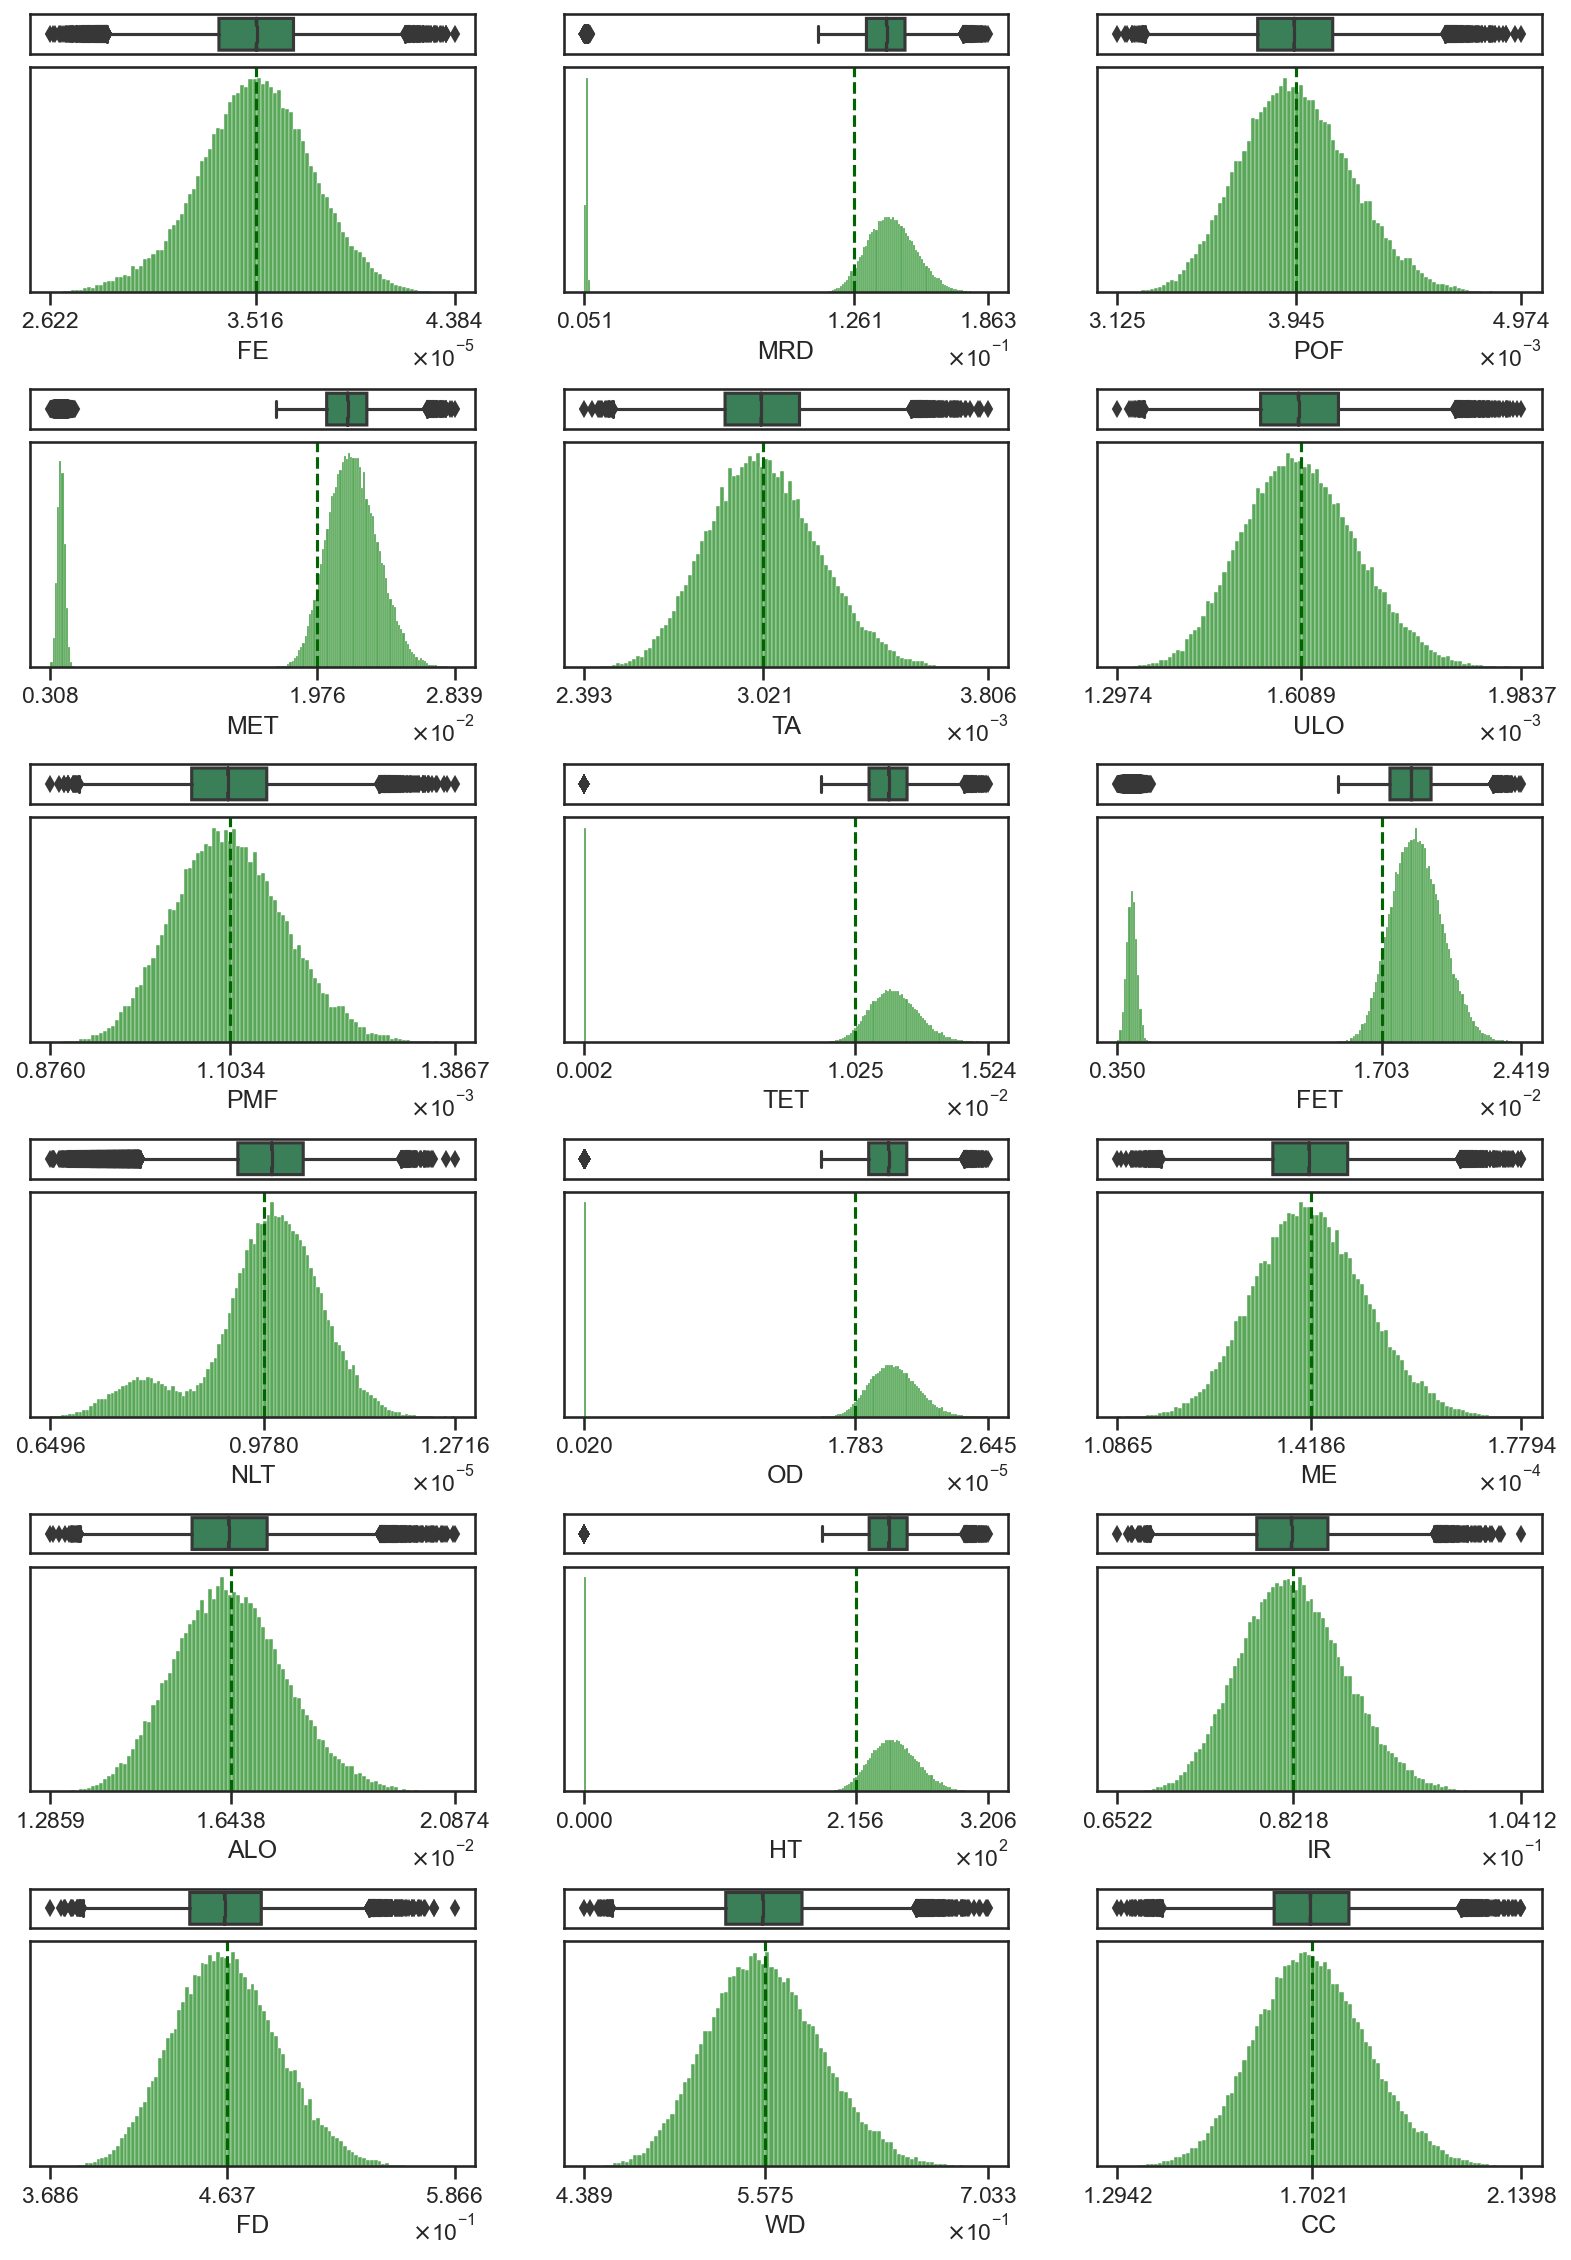

In [27]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

original.dist('MP', save=False)

Mean midpoint results are shown below.

In [75]:
og_mean = original.mean('MP', by='sum').to_pandas().rename("Original - no pesticide")
og_pest_mean = original_pest.mean('MP', by='sum').to_pandas().rename("Original - with pesticide")

mid_mean = midlife.mean('MP', by='sum').to_pandas().rename("Updated - no pesticide")
mid_pest_mean = midlife_pest.mean('MP', by='sum').to_pandas().rename("Updated - with pesticide")

at_mean = at.mean('MP', by='sum').to_pandas().rename("AT - no pesticide")
at_pest_mean = at_pest.mean('MP', by='sum').to_pandas().rename("AT - with pesticide")

In [82]:
mean_results = pd.DataFrame()
mean_results = mean_results.append([og_mean, og_pest_mean, mid_mean, mid_pest_mean, at_mean, at_pest_mean]).transpose()

In [84]:
relative_mean_results = pd.DataFrame()

for cat in mean_results:
    relative_mean_results[cat] = mean_results[cat] / mean_results["Original - no pesticide"]

In [87]:
with pd.ExcelWriter("Outputs/Iris_mean_results.xlsx") as writer:
    mean_results.to_excel(writer, sheet_name="absolute")
    relative_mean_results.to_excel(writer, sheet_name="relative")

Next, we calculate mean midpoint impacts per life cycle phase using the `LCIA.bar()` method.

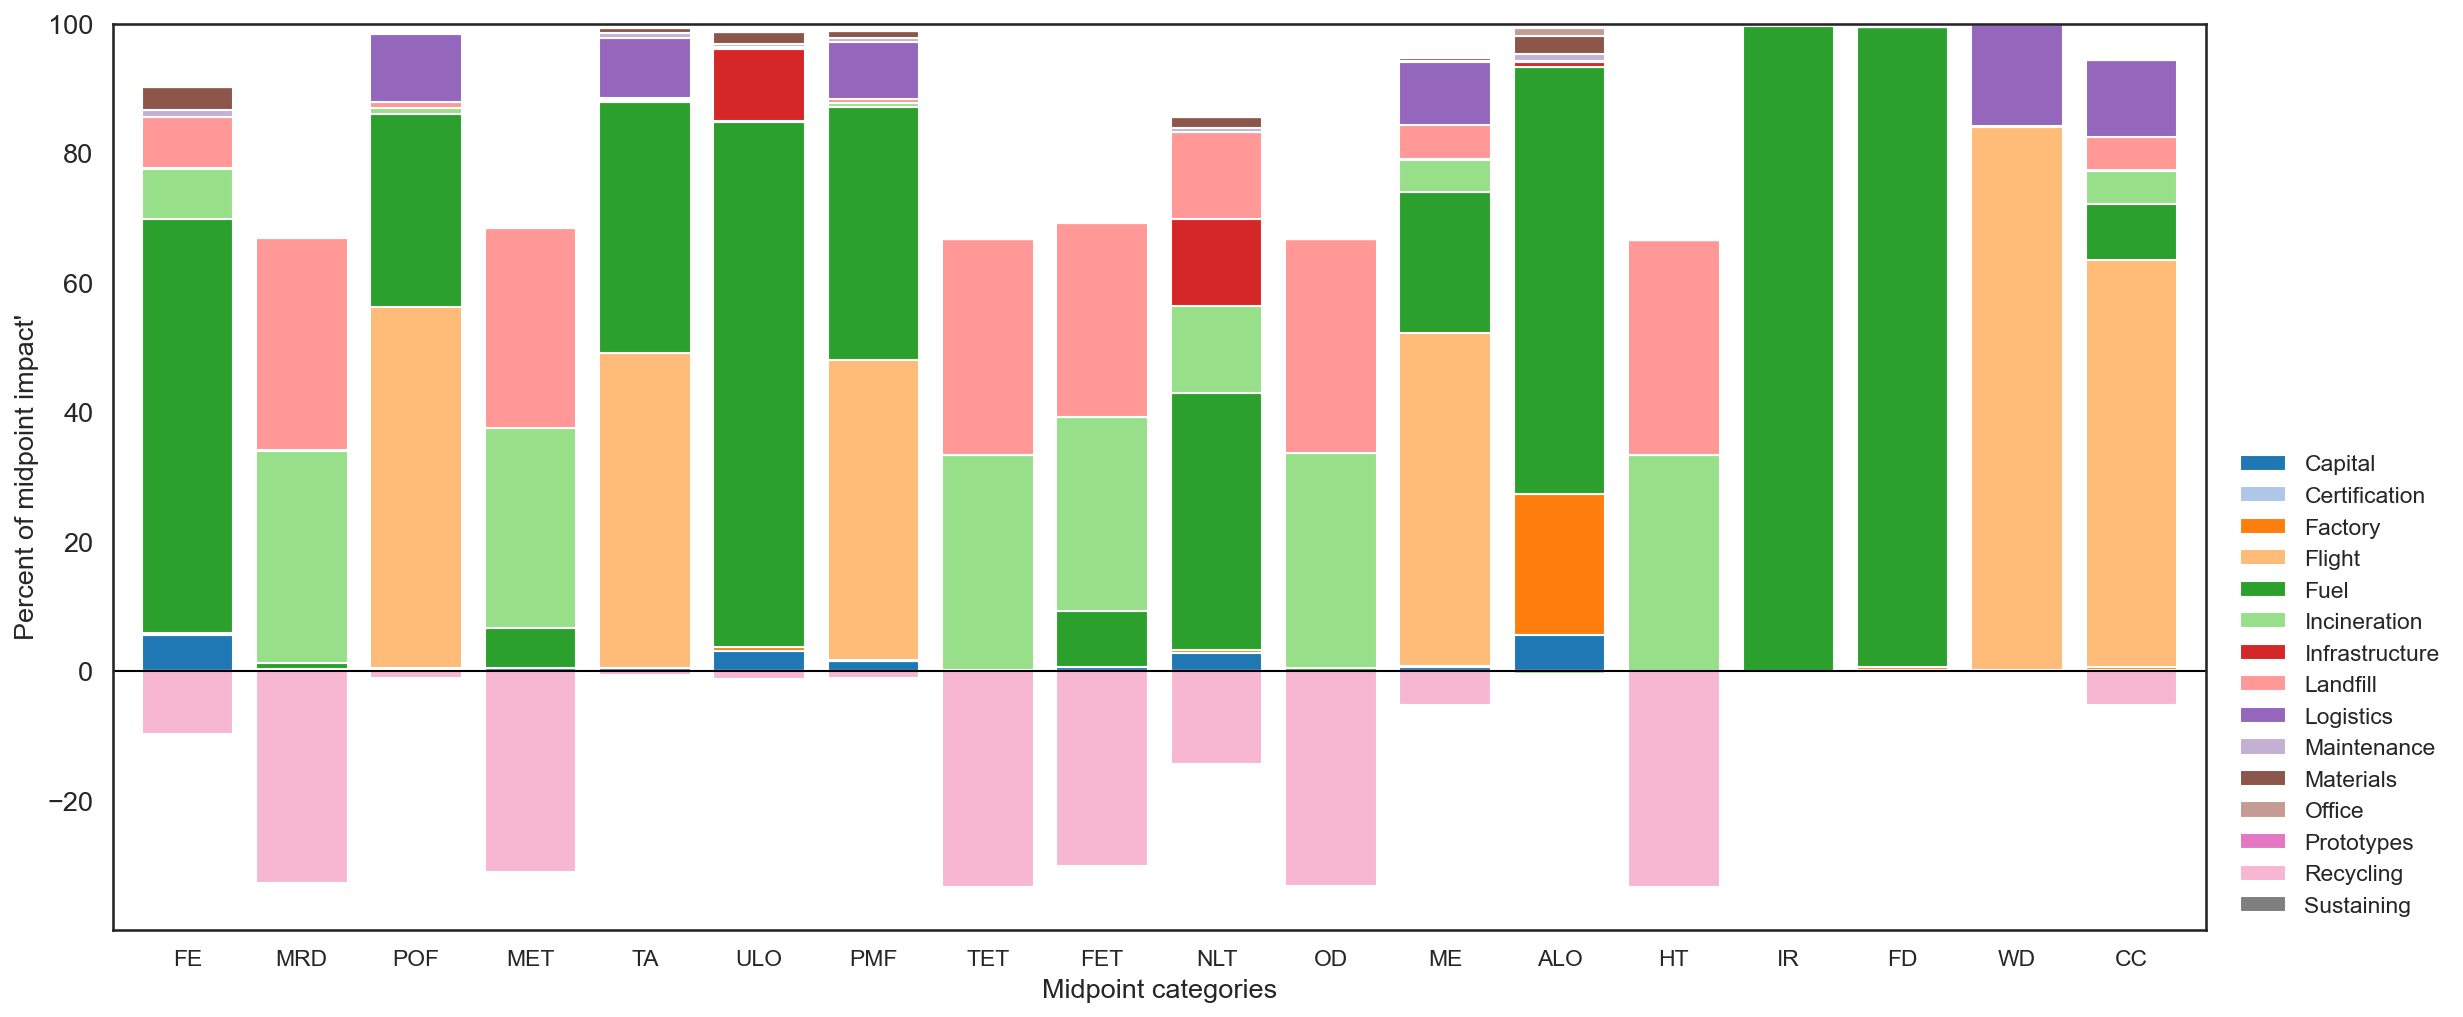

In [89]:
original.bar('MP', subphase=True, save=True, palette="tab20")

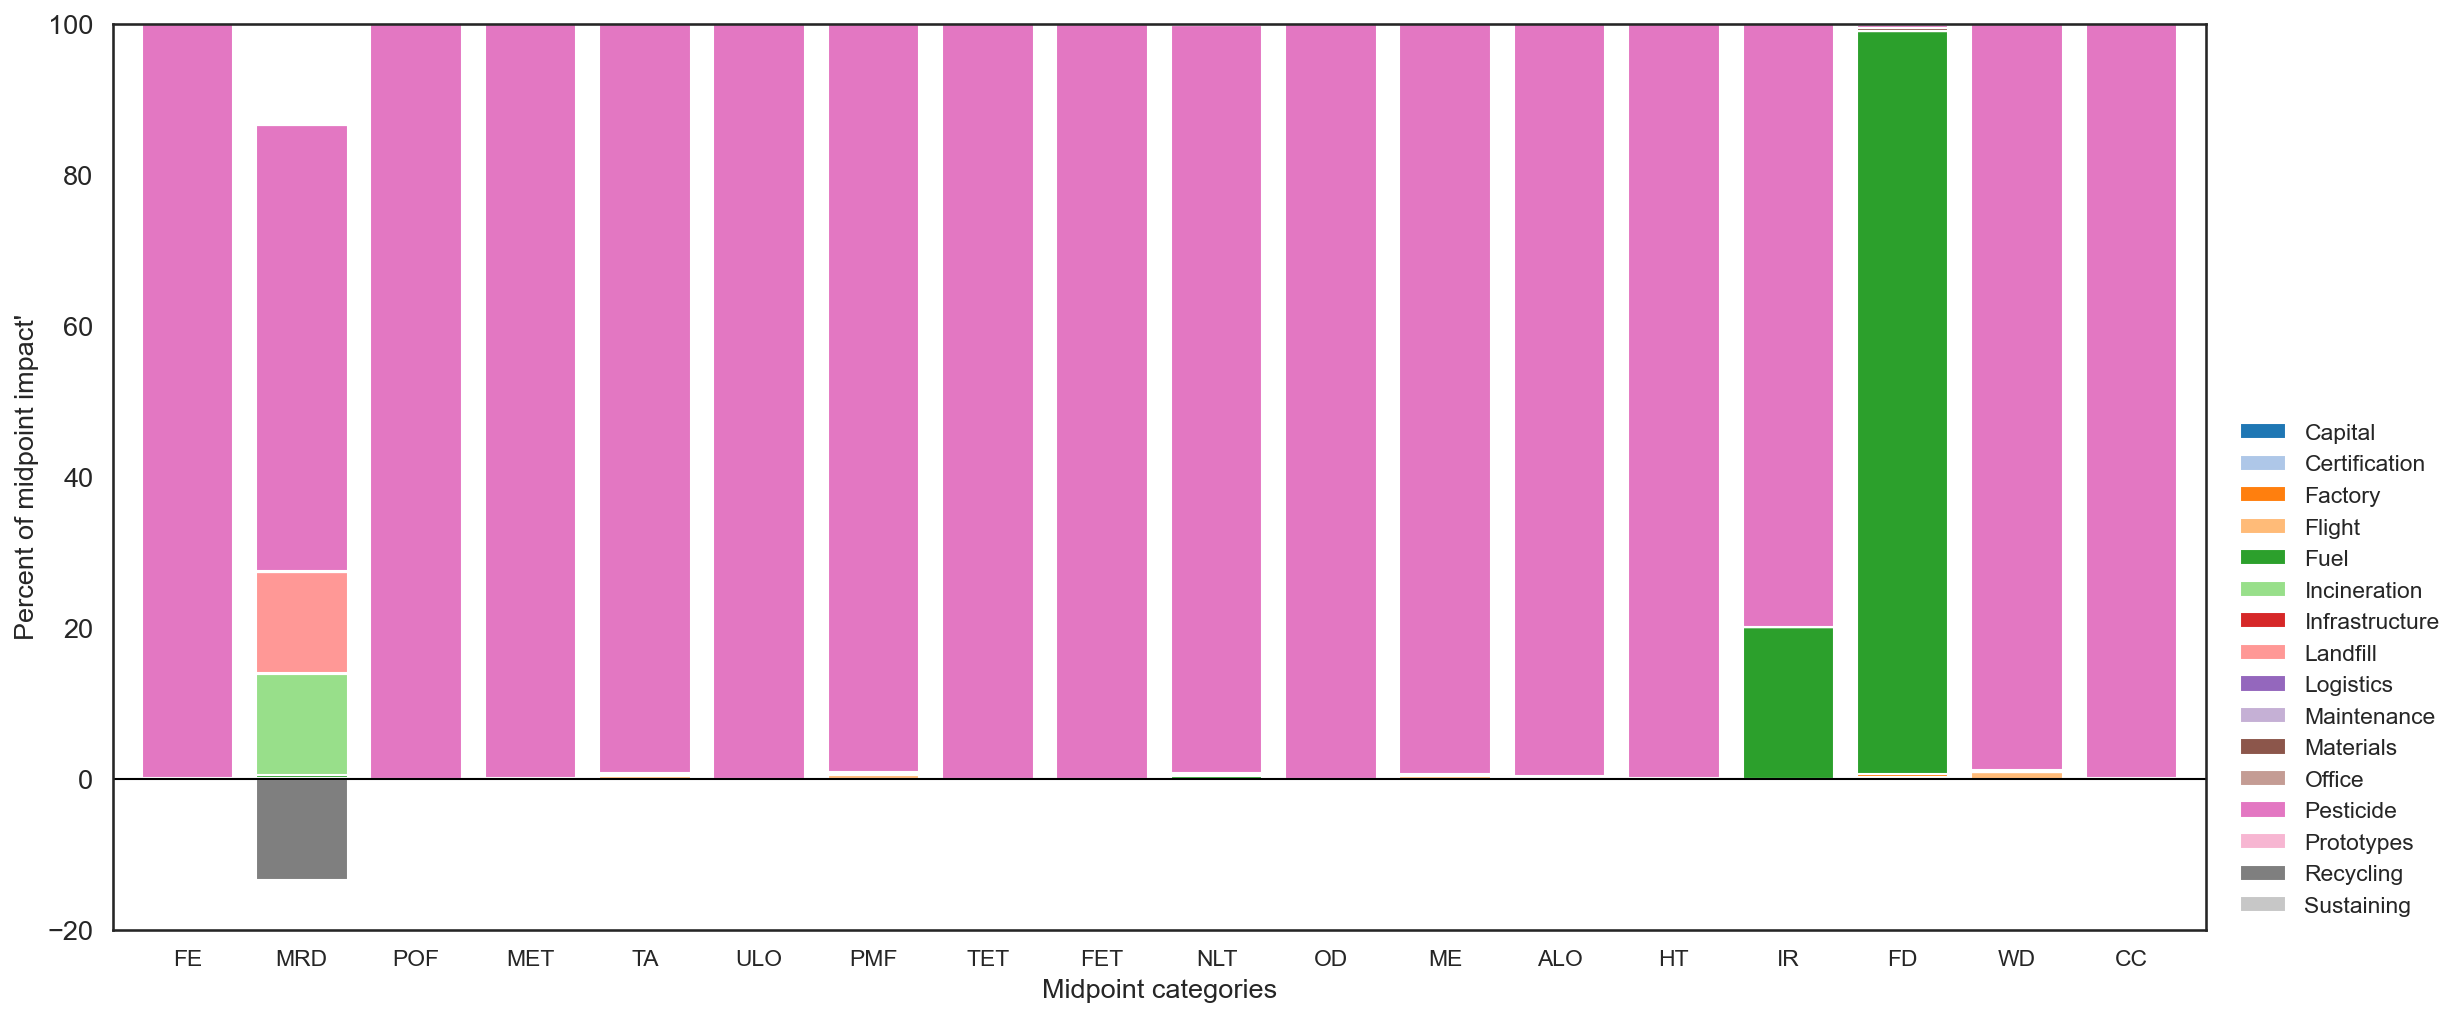

In [90]:
original_pest.bar('MP', subphase=True, save=False, palette='tab20')

# Endpoint Results

The distributions of the endpoint results, considering all the iterations, are plotted for each impact category using the `LCIA.dist()` method.

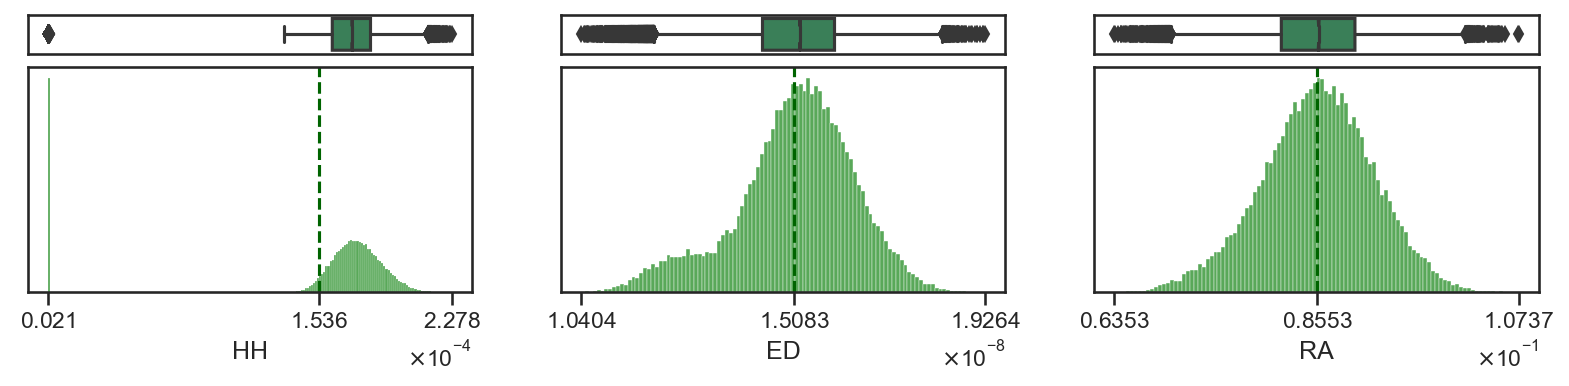

In [94]:
original.dist('EP', save=False)

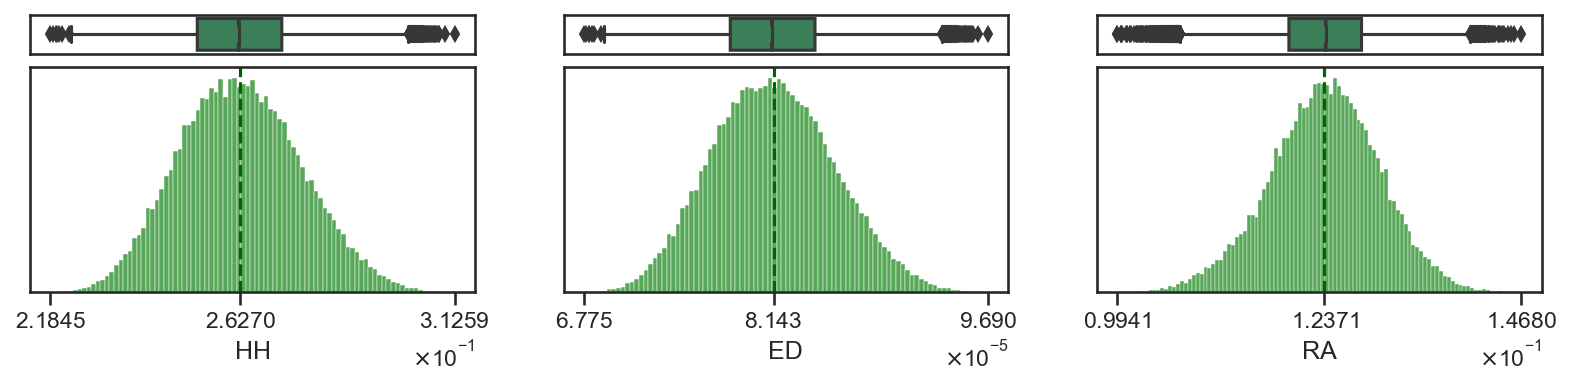

In [95]:
original_pest.dist('EP', save=False)

Mean endpoint results are shown below.

In [96]:
og_mean = original.mean('EP', by='sum').to_pandas().rename("Original - no pesticide")
og_pest_mean = original_pest.mean('EP', by='sum').to_pandas().rename("Original - with pesticide")

mid_mean = midlife.mean('EP', by='sum').to_pandas().rename("Updated - no pesticide")
mid_pest_mean = midlife_pest.mean('EP', by='sum').to_pandas().rename("Updated - with pesticide")

at_mean = at.mean('EP', by='sum').to_pandas().rename("AT - no pesticide")
at_pest_mean = at_pest.mean('EP', by='sum').to_pandas().rename("AT - with pesticide")

In [97]:
mean_results = pd.DataFrame()
mean_results = mean_results.append([og_mean, og_pest_mean, mid_mean, mid_pest_mean, at_mean, at_pest_mean]).transpose()

In [98]:
relative_mean_results = pd.DataFrame()

for cat in mean_results:
    relative_mean_results[cat] = mean_results[cat] / mean_results["Original - no pesticide"]

In [99]:
with pd.ExcelWriter("Outputs/Iris_mean_results.xlsx", mode='a') as writer:
    mean_results.to_excel(writer, sheet_name="absolute - EP")
    relative_mean_results.to_excel(writer, sheet_name="relative - EP")

Endpoint impacts per life cycle phase are plotted with the `LCIA.bar()` method.

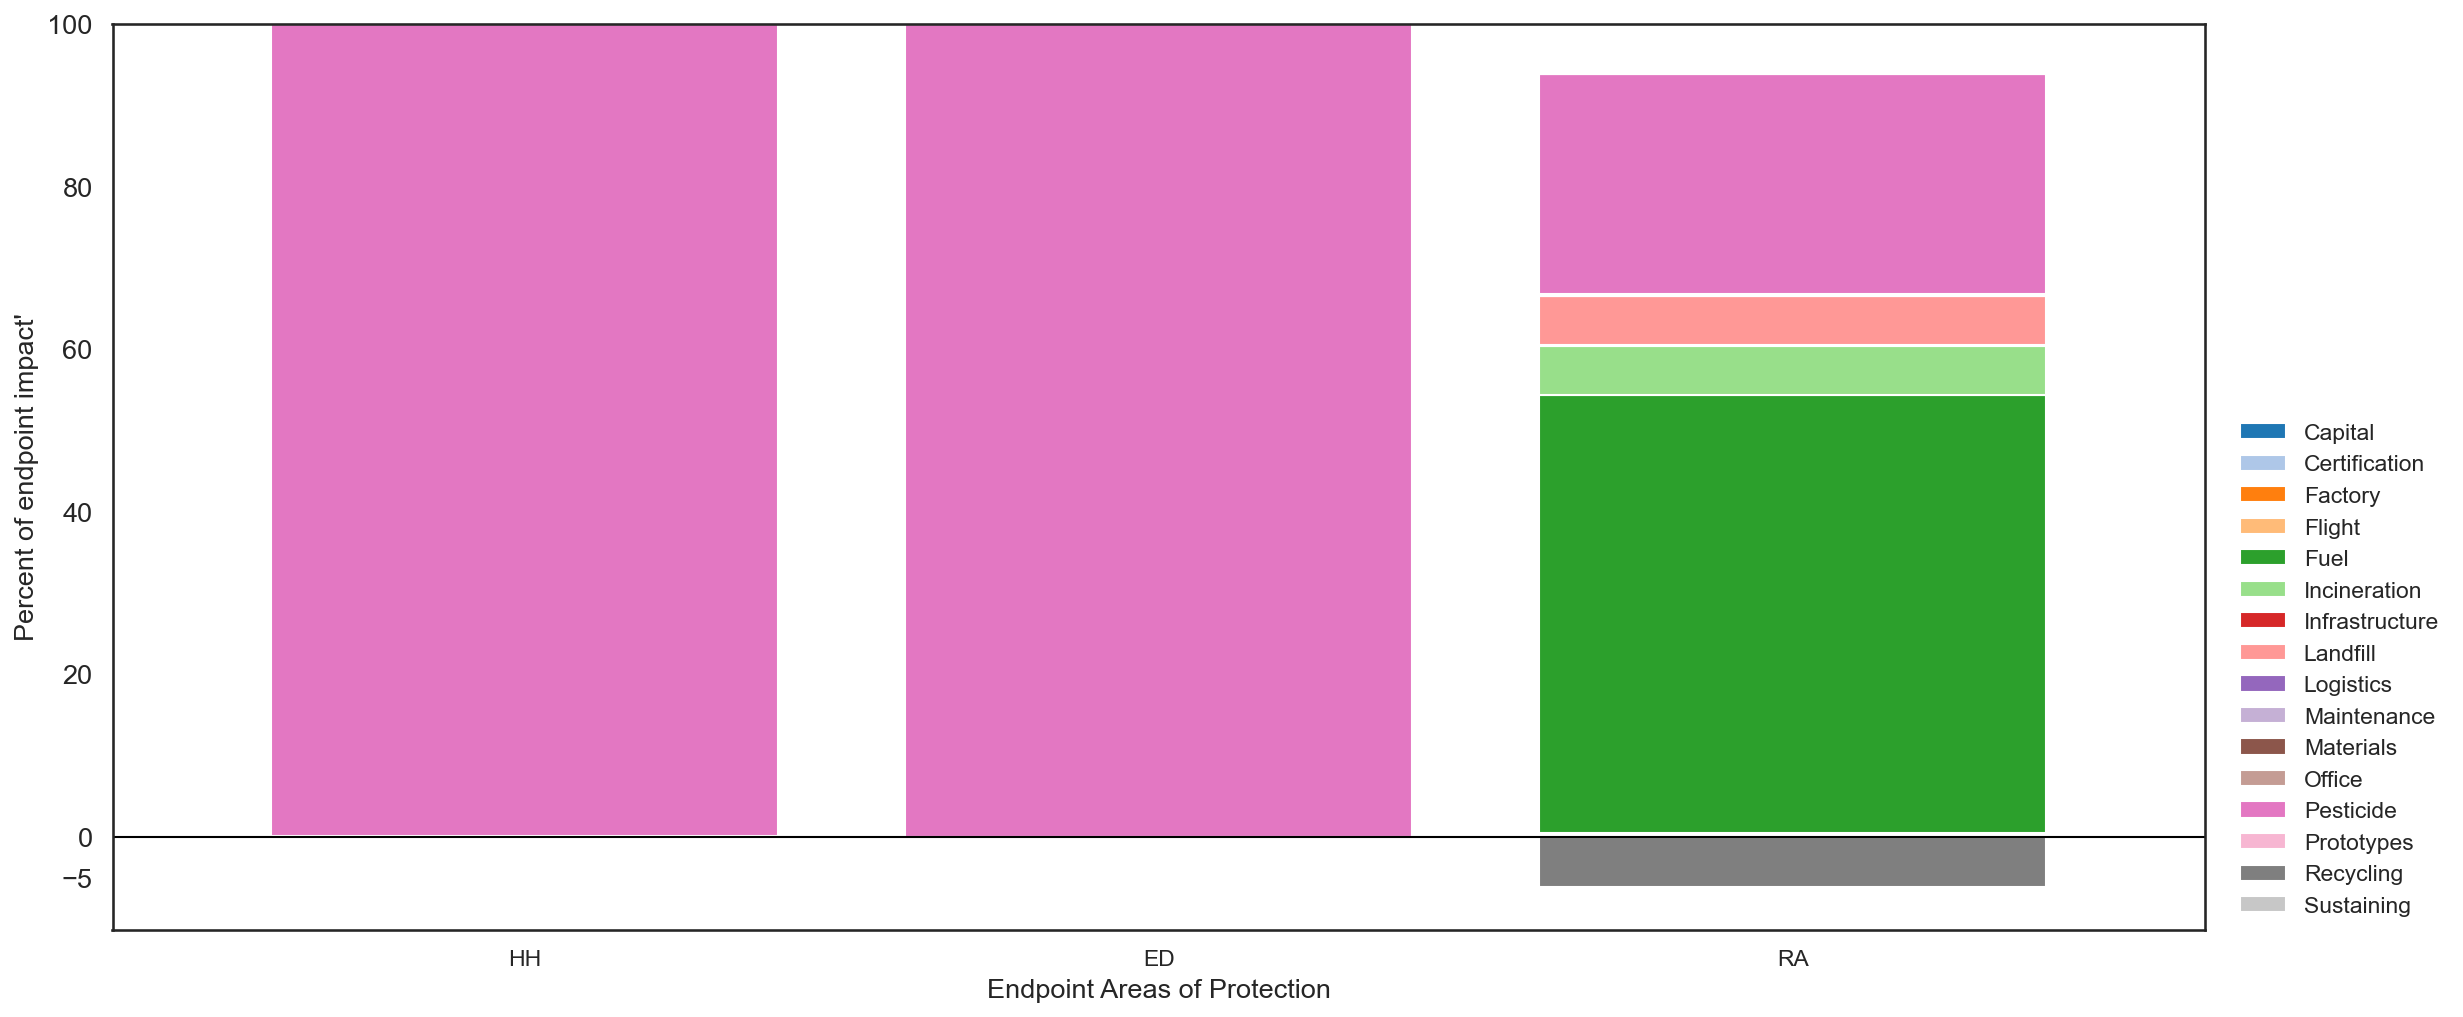

In [100]:
original_pest.bar('EP', subphase=True, save=False, palette='tab20')

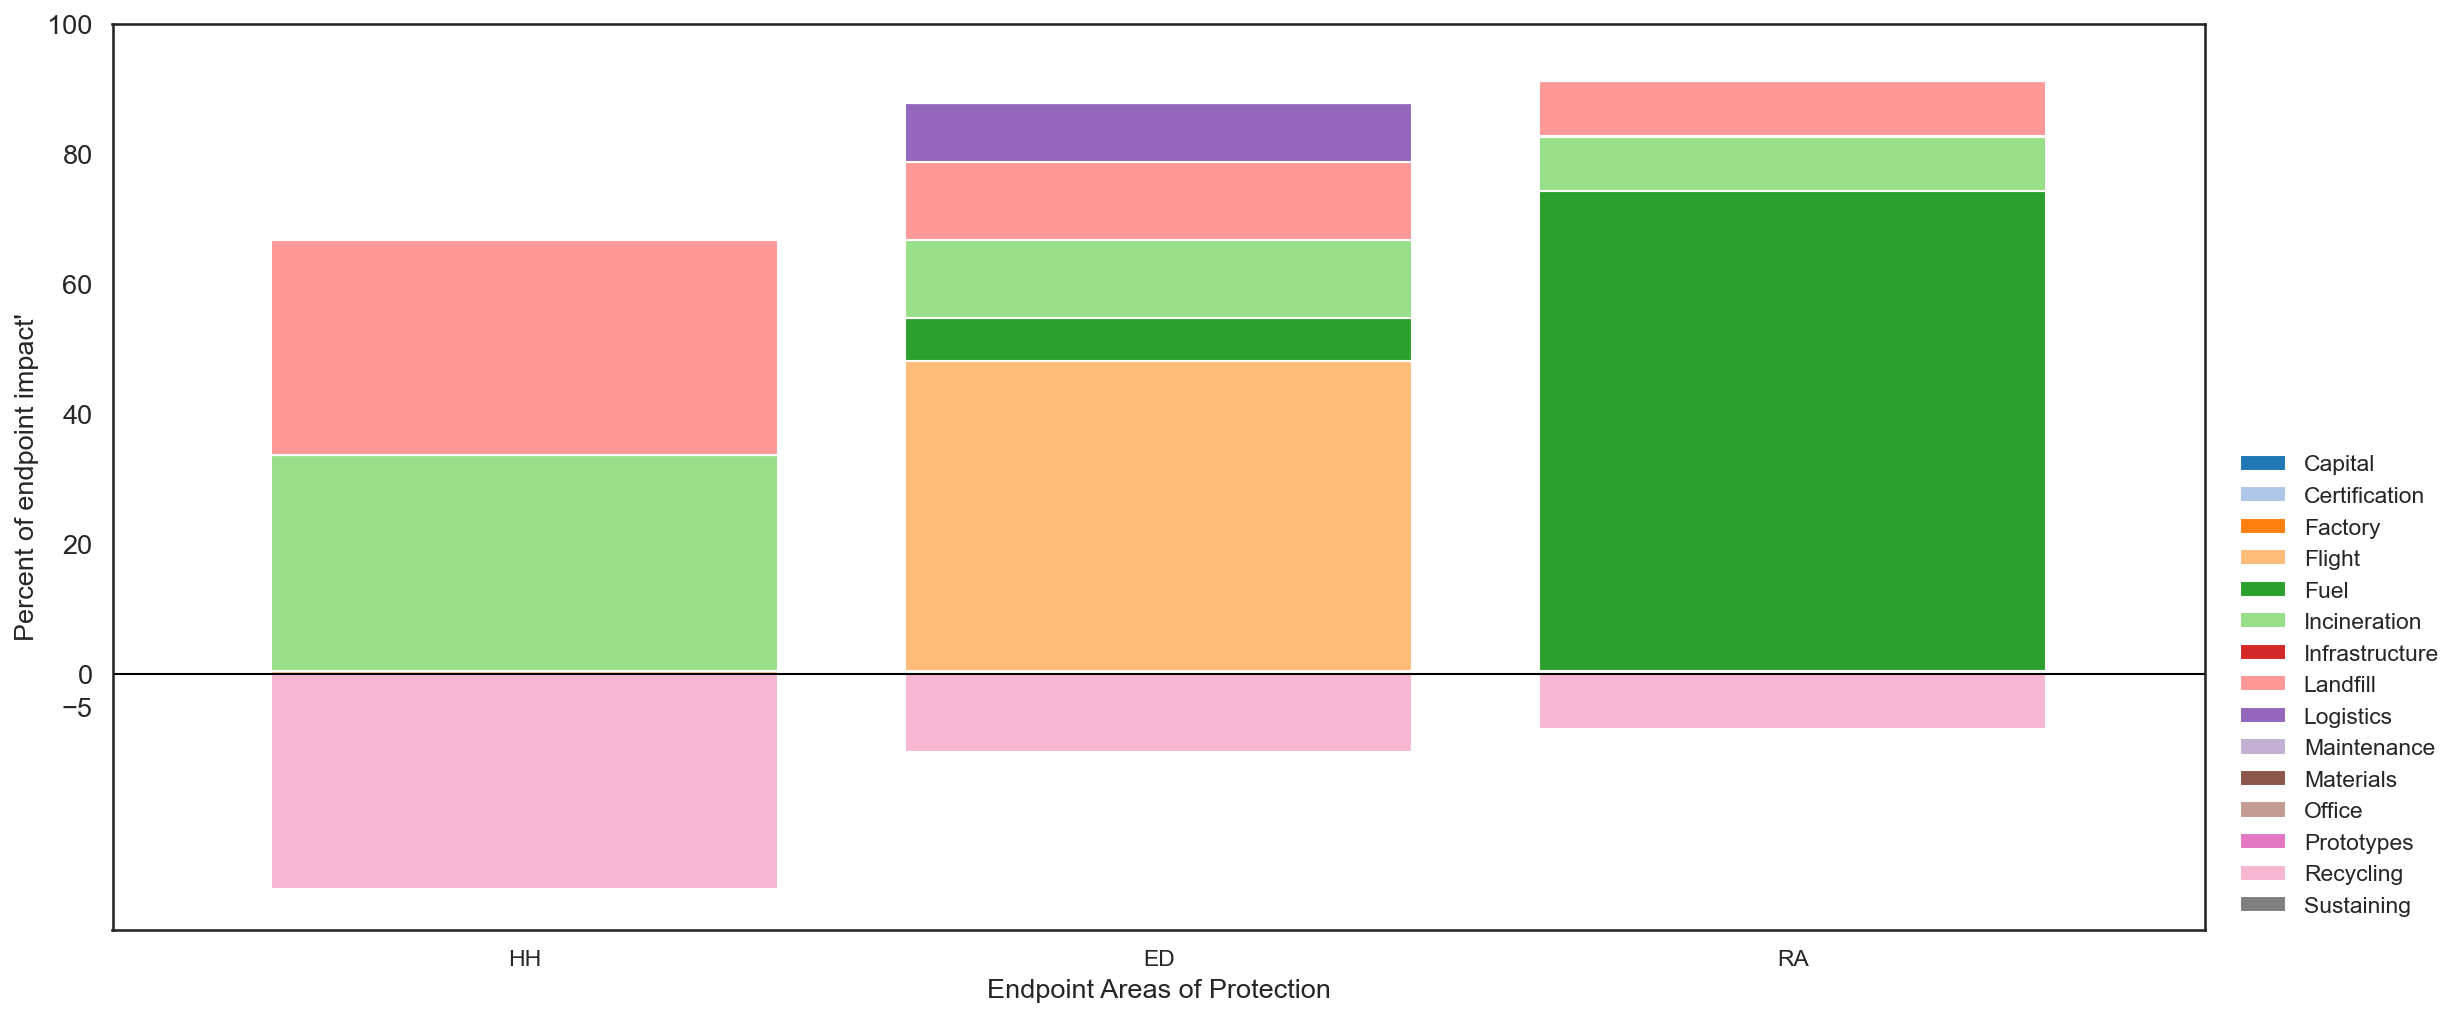

In [103]:
at.bar('EP', subphase=True, save=False, palette='tab20')

# Single Score Results

Mean SS results are shown below.

In [104]:
original.SS("sum").mean('i').compute()

<xarray.DataArray ()>
array(0.41990466)

In [105]:
midlife.SS("sum").mean('i').compute()

<xarray.DataArray ()>
array(0.38495053)

In [106]:
at.SS("sum").mean('i').compute()

<xarray.DataArray ()>
array(0.47226145)

# CTV Results

The areas in the following plots represent CTV for each input parameters. Each plot concerns one midpoint or endpoint result. This plot is accessed through the `LCIA.square()` method.

In [73]:
antera_pest.square(save=False)

TypeError: 'NoneType' object is not iterable

# Comparison

Comparison of two Datasets of LCIA results can be achieved by the `LCIA.compare` method, indicating the desired pathway.
In this paired comparison method, the iterations of the "Numerator" Dataset are divided by the "Denominator" Dataset, generating a Dataset of ratios. 

This new comparison Dataset has the same number of iterations than the original LCIA results Datasets, but, this time, each iteration represents a ratio.
Ratios less than one mean that the "Numerator" Dataset is advantageous, while ratios greater than one mean that the "Denominator" Dataset is favourable.
Using this logic, we can have an idea of which aircraft concept has fewer impacts by computing the mean of the iterations, using the `.mean('i')` or `.median('i')` command.

In [121]:
iris_mp = original_pest.compare(midlife_pest, pathway="MP")
iris_ep = original_pest.compare(midlife_pest, pathway="EP")

In [122]:
display(iris_mp.compute().median('i'))
display(iris_ep.compute().median('i'))

<xarray.Dataset>
Dimensions:  ()
Data variables: (12/18)
    FE       float64 1.334
    MRD      float64 1.233
    POF      float64 1.334
    MET      float64 1.334
    TA       float64 1.332
    ULO      float64 1.334
    ...       ...
    ALO      float64 1.333
    HT       float64 1.334
    IR       float64 1.281
    FD       float64 1.103
    WD       float64 1.331
    CC       float64 1.334

<xarray.Dataset>
Dimensions:  ()
Data variables:
    HH       float64 1.334
    ED       float64 1.334
    RA       float64 1.155

All Categories and all AOP have mean results slightly lower than one, meaning the Echo concept is slightly advantageous.

The same point can be proven by using the `comparePercent` function.
The function shows, in percentage, how many of the iterations are below the threshold of one, meaning how many iterations favour Echo over Bravo.

In [123]:
display(comparePercent(iris_mp))
display(comparePercent(iris_ep))

<xarray.Dataset>
Dimensions:  ()
Data variables: (12/18)
    FE       float64 0.0
    MRD      float64 6.94
    POF      float64 0.0
    MET      float64 0.0
    TA       float64 0.0
    ULO      float64 0.0
    ...       ...
    ALO      float64 0.0
    HT       float64 0.0
    IR       float64 0.0
    FD       float64 12.64
    WD       float64 0.0
    CC       float64 0.0
Attributes:
    Numerator:    Iris_original
    Denominator:  Iris_midlife

<xarray.Dataset>
Dimensions:  ()
Data variables:
    HH       float64 0.0
    ED       float64 0.0
    RA       float64 3.024
Attributes:
    Numerator:    Iris_original
    Denominator:  Iris_midlife

This can be better visualized using the `LCIA.dist_compare()` method, which plots the paired distribution of both concepts.

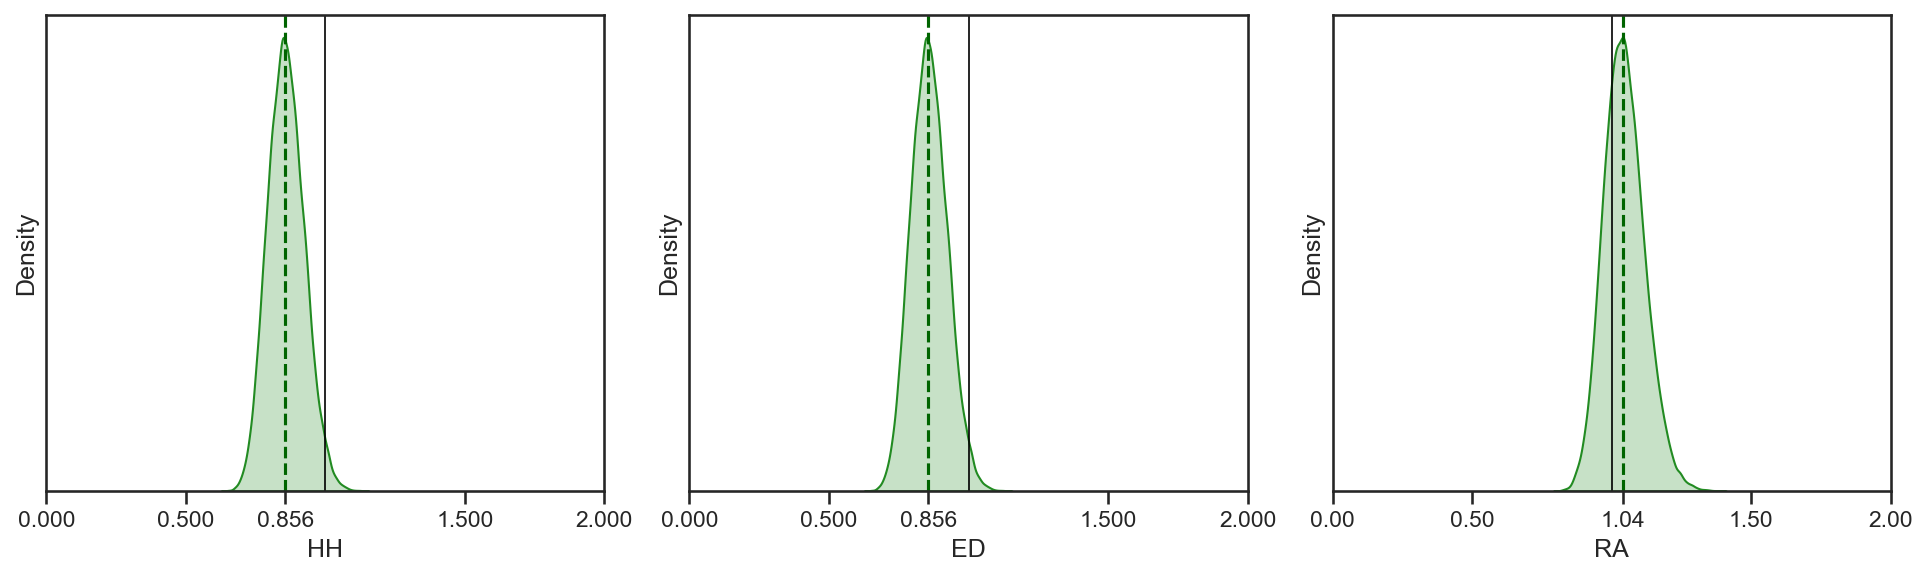

In [119]:
at_pest.dist_compare(original_pest, pathway='EP', save=False)

## Scenarios

In [139]:
import os
os.chdir("C:/Users/giparoli/Documents/Projetos/AEco")

iris_path_scenarios = '.\\Local\\Iris_pestreduct_outputs'  # LCA results file path

In [140]:
scenario_pest = LCIA.load(iris_path_scenarios, chunks={}, LCI=False, CTV=False)
scenario = LCIA.load(iris_path_scenarios, chunks={}, LCI=False, CTV=False, no_pest=True, phases=no_pest_phases)

# antera_pest = LCIA.load(antera_path, chunks={}, LCI=False, CTV=False)
# antera_no_pest = LCIA.load(antera_path, chunks={}, LCI=False, CTV=False, no_pest=True, phases=no_pest_phases)

In [142]:
scenario_pest.mean('EP', by='sum').to_pandas()

AOP
HH    0.193930
ED    0.000060
RA    0.107773
dtype: float64

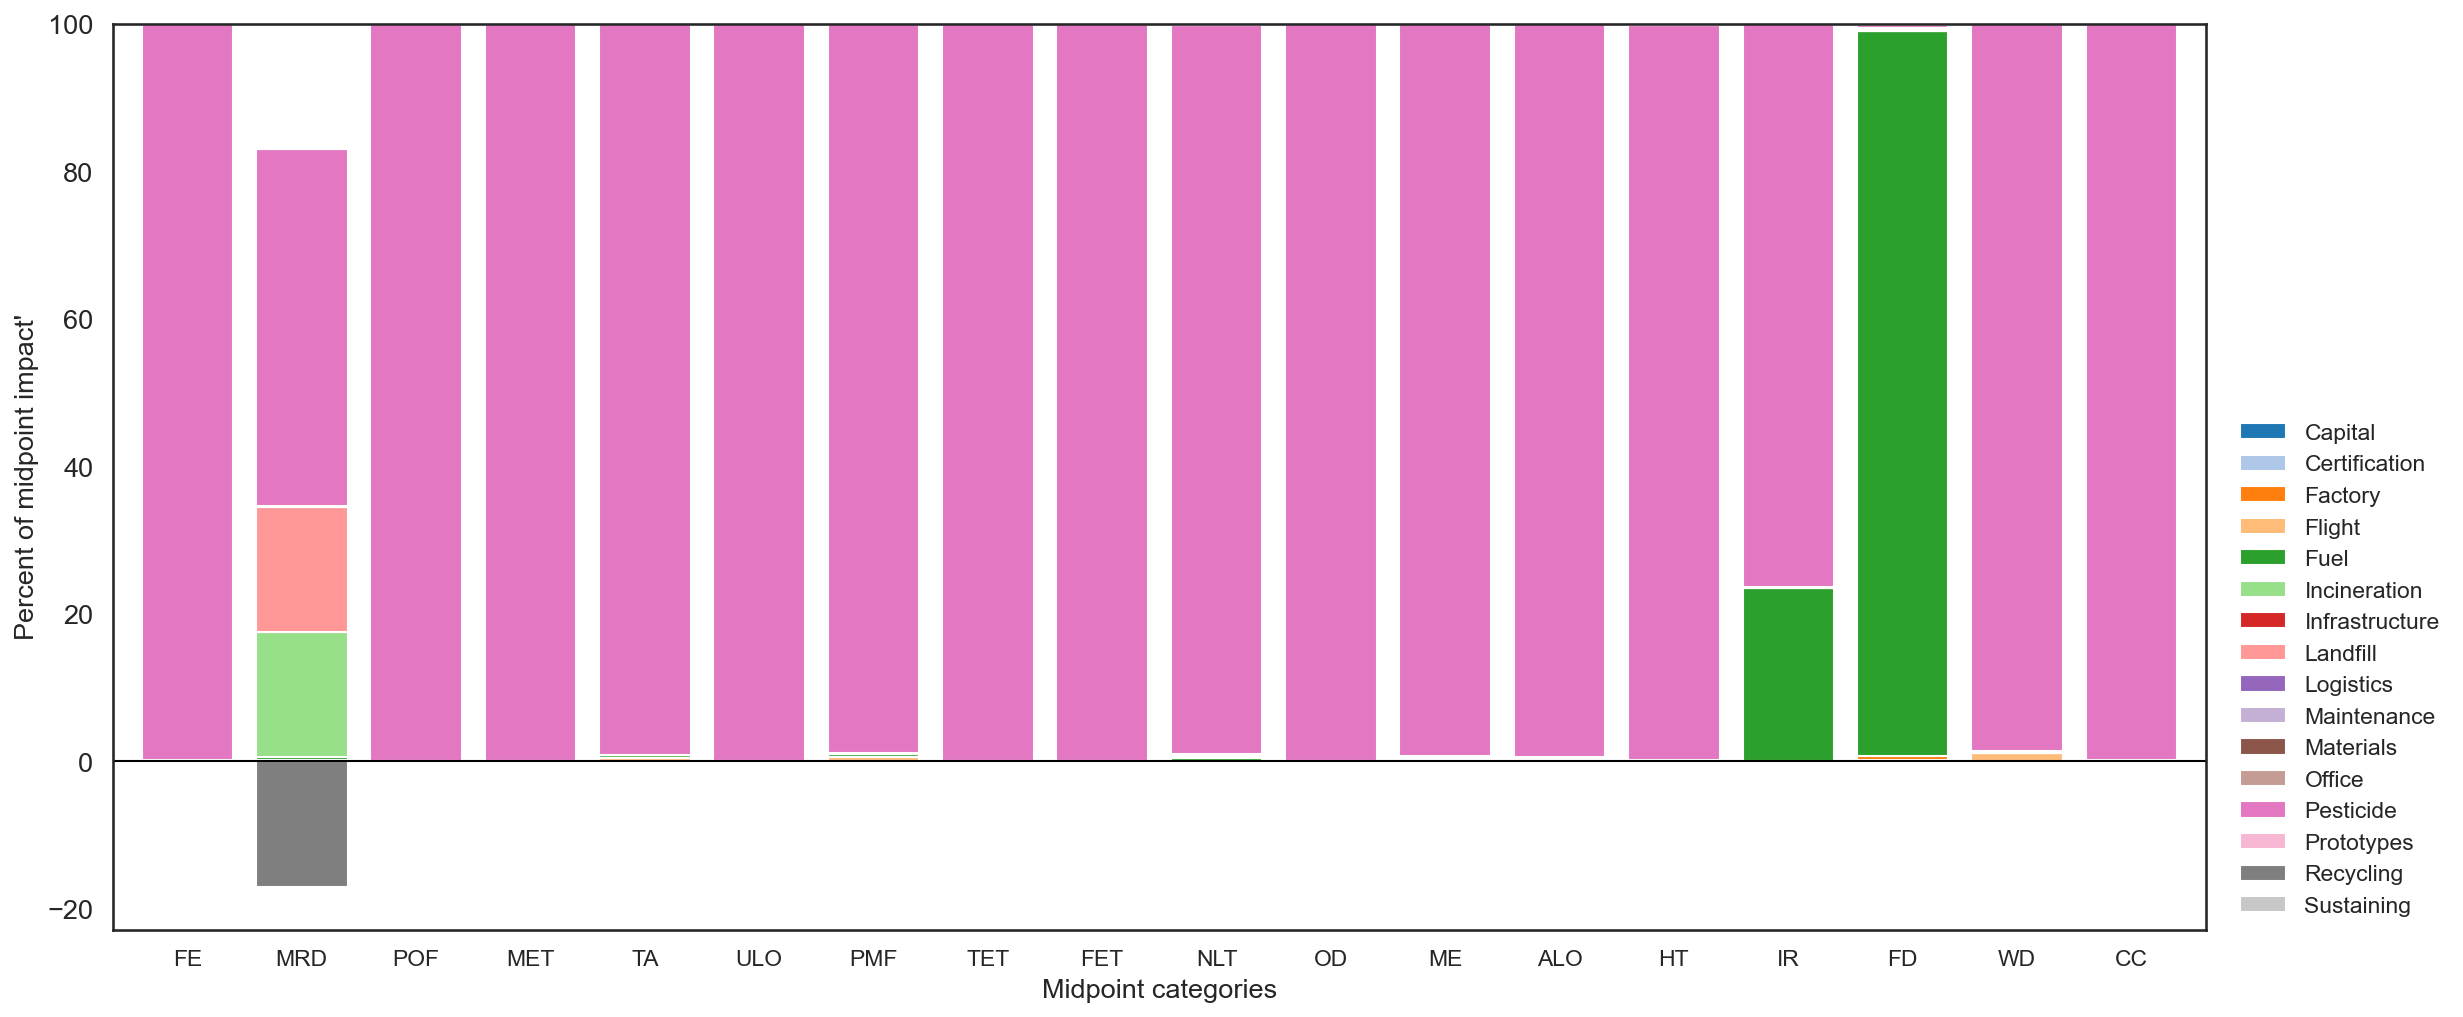

In [144]:
scenario_pest.bar(palette="tab20")